# Simulations light inter

In [1]:
from __future__ import annotations

import time as t

import matplotlib.pyplot as plt
import numpy as np
from archi_dict import archi
from oawidgets.plantgl import *  # noqa: F403

from openalea.archicrop.display import build_scene, display_scene  # noqa: F401
from openalea.archicrop.simulation import plot_constrainted_vs_realized, run_simulations
from openalea.plantgl.all import Color3, Material, Scene  # noqa: F401

%gui qt

In [2]:
stics_color = "orange"
archicrop_color = "green"

In [3]:
tec_file_xml='Mais_tec.xml'
plt_file_xml='corn_plt.xml'
stics_output_file='mod_smaize.sti'
weather_file = 'climaisj.meteo'
location = {  
'longitude': 3.87,
'latitude': 45,
'altitude': 800,
'timezone': 'Europe/Paris'}

In [4]:

start_time = t.time()

daily_dynamics, fit_params, non_fit_params, pot_la, pot_h, realized_la, realized_h, nrj_per_plant, mtgs, sowing_density = run_simulations(
    archi_params=archi, 
    tec_file=tec_file_xml, 
    plant_file=plt_file_xml, 
    dynamics_file=stics_output_file, 
    weather_file=weather_file,
    location=location,
    n_samples=100000,
    latin_hypercube=True,
    opt_filter_pot_growth=True,
    opt_filter_realized_growth=False)

end_time = t.time()

elapsed_time = (end_time - start_time)/60
print(f"Elapsed time: {elapsed_time:.4f} minutes for {len(realized_la)} simulations")  # noqa: T201


Elapsed time: 32.5178 minutes for 4 simulations


In [5]:
# Retrieve STICS growth and senescence dynamics
dates = [value["Date"] for value in daily_dynamics.values()]
thermal_time = [value["Thermal time"] for value in daily_dynamics.values()]
leaf_area_plant = [value["Plant leaf area"] for value in daily_dynamics.values()]
sen_leaf_area_plant = [value["Plant senescent leaf area"] for value in daily_dynamics.values()]
height_canopy = [value["Plant height"] for value in daily_dynamics.values()]
par_incident = [value["Incident PAR"] for value in daily_dynamics.values()]
par_stics = [value["Absorbed PAR"] for value in daily_dynamics.values()]

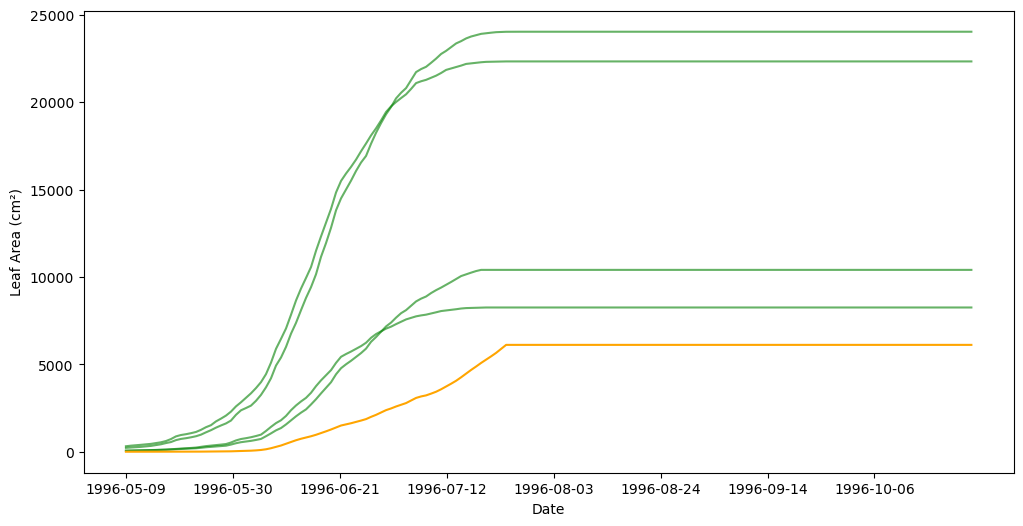

In [6]:
fig, ax = plt.subplots(figsize=(12, 6))
for la in pot_la:
    ax.plot(dates, la, color=archicrop_color, alpha=0.6)
ax.plot(dates, leaf_area_plant, color=stics_color)
ax.set_xticks(np.arange(0, len(dates)+1, (len(dates)+1)/8))
ax.set_xlabel("Date")
ax.set_ylabel("Leaf Area (cm²)")
plt.show()

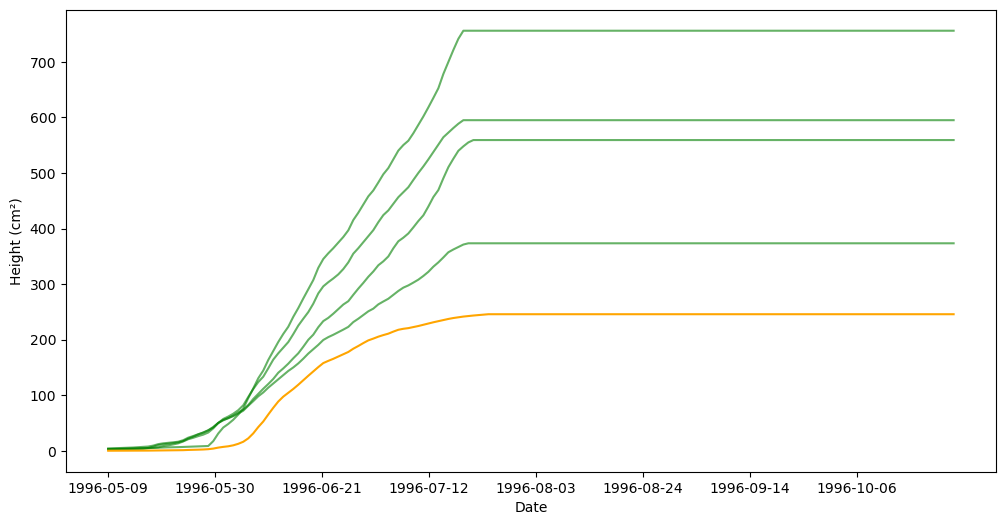

In [7]:
fig, ax = plt.subplots(figsize=(12, 6))
for h in pot_h:
    ax.plot(dates, h, color=archicrop_color, alpha=0.6)
ax.plot(dates, height_canopy, color=stics_color)
ax.set_xticks(np.arange(0, len(dates)+1, (len(dates)+1)/8))
ax.set_xlabel("Date")
ax.set_ylabel("Height (cm²)")
plt.show()

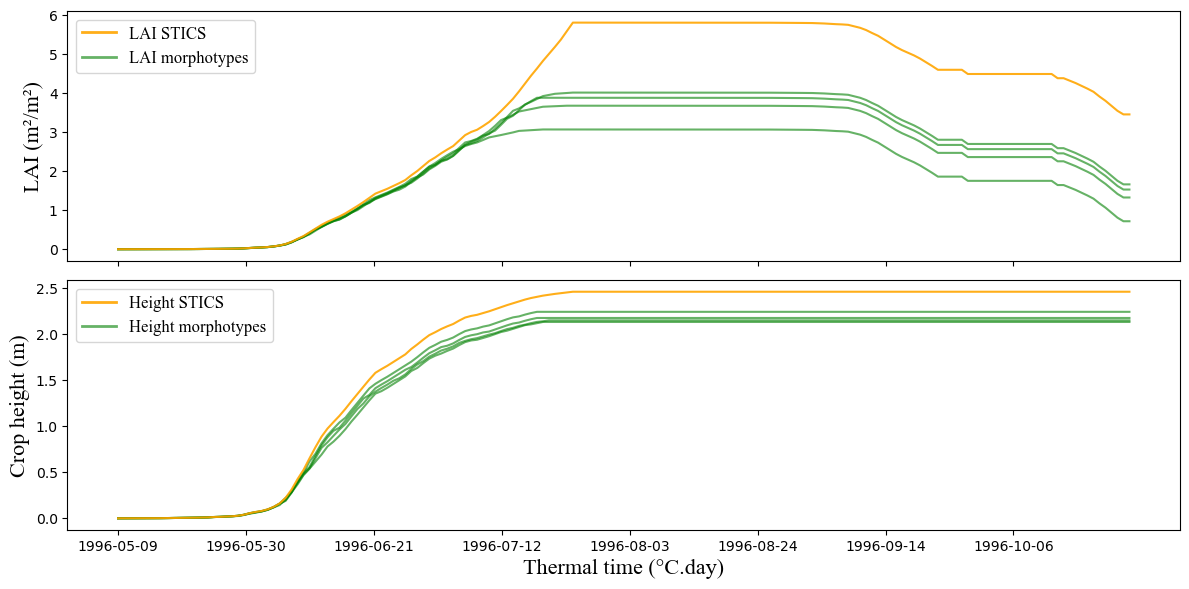

In [8]:
plot_constrainted_vs_realized(dates=dates, 
                              LA_archicrop=realized_la, 
                              height_archicrop=realized_h, 
                              leaf_area_plant=leaf_area_plant, 
                              sen_leaf_area_plant=sen_leaf_area_plant, 
                              height_canopy=height_canopy, 
                              sowing_density=sowing_density)


In [9]:
# Energy in Caribu : W = 0.0864 MJ.day-1
# Irradiance in Caribu : W.m-2 = 0.0864 MJ.m[leaf]-2.day-1
# Incident PAR in STICS : MJ.m[soil]-2.day-1
# Absorbed PAR in STICS : MJ.m[soil]-2.day-1

In [15]:
from alinea.caribu.CaribuScene import CaribuScene

from openalea.archicrop.display import build_scene
from openalea.archicrop.light_it import illuminate, mean_leaf_irradiance
from openalea.archicrop.stand import compute_domain
from openalea.archicrop.stics_io import stics_weather_3d
from openalea.astk.sky_irradiance import sky_irradiance
from openalea.astk.sky_sources import caribu_light_sources, sky_sources

# Read weather data
df_weather = stics_weather_3d(filename=weather_file, daily_dynamics=daily_dynamics)

# Sowing pattern
inter_row = 70
domain = compute_domain(sowing_density, inter_row = inter_row) # cm

# Define incident PAR
par_incident = df_weather.itertuples()

# Compute light interception for each plant at each time step
par_caribu = []
for mtgs_plant in mtgs:
    aggs_tmp = []
    # For each time step
    for i,(mtg, par) in enumerate(zip(mtgs_plant, par_incident)):
        # if i%1==0:
        # Compute light sources
        irr = sky_irradiance(daydate=par.daydate, day_ghi=par.rad, **location)
        sun, sky = sky_sources(sky_type='clear_sky', sky_irradiance=irr, scale='global')
        lights = caribu_light_sources(sun, sky)
        # Build and illuminate scene
        scene, labels = build_scene(mtg, (0,0,0), senescence=False)
        cs, raw, agg = illuminate(scene, light=lights, labels=labels, domain=domain, direct=False) # --> cf PARaggregators in caribu scene node
        aggs_tmp.append(agg)

    par_caribu.append(aggs_tmp)

# Calculate energy per leaf and irradiance per plant
nrj_per_leaf = []
# irr_per_plant = []

for illuminated_plant in par_caribu:
    nrj_tmp = []
    # irr_tmp = []
    for df_scene in illuminated_plant:
        df_mod = mean_leaf_irradiance(df_scene)  # noqa: F841
        nrj_tmp.append(df_scene.loc[df_scene['label'] == 'Leaf']['Energy'].values)
        # irr_tmp.append(df_mod['Irradiance'].values[0])  
    nrj_per_leaf.append(nrj_tmp)
    # irr_per_plant.append(irr_tmp)

nrj_per_plant = [[sum(growing_plant) for growing_plant in plant] for plant in nrj_per_leaf]


In [ ]:
# 30 minutes per plant on whole growth cycle

In [26]:
par_incident = df_weather.itertuples()
list(par_incident)

[Pandas(Index=129, station='climais', year=1996, month=5, day=9, julian=130, min_temp=7.2, max_temp=13.1, rad=15.1, _9=2.7, rainfall=0.0, wind=-999.9, pressure=-999.9, CO2=330.0, daydate=Timestamp('1996-05-09 00:00:00')),
 Pandas(Index=130, station='climais', year=1996, month=5, day=10, julian=131, min_temp=4.3, max_temp=13.4, rad=24.4, _9=2.9, rainfall=0.0, wind=-999.9, pressure=-999.9, CO2=330.0, daydate=Timestamp('1996-05-10 00:00:00')),
 Pandas(Index=131, station='climais', year=1996, month=5, day=11, julian=132, min_temp=3.9, max_temp=14.5, rad=20.3, _9=3.4, rainfall=0.0, wind=-999.9, pressure=-999.9, CO2=330.0, daydate=Timestamp('1996-05-11 00:00:00')),
 Pandas(Index=132, station='climais', year=1996, month=5, day=12, julian=133, min_temp=4.4, max_temp=14.8, rad=13.7, _9=2.3, rainfall=0.0, wind=-999.9, pressure=-999.9, CO2=330.0, daydate=Timestamp('1996-05-12 00:00:00')),
 Pandas(Index=133, station='climais', year=1996, month=5, day=13, julian=134, min_temp=4.7, max_temp=13.7, ra

In [24]:
for mtgs_plant in mtgs:
    aggs_tmp = []
    # For each time step
    for i,mtg in enumerate(mtgs_plant):
        print(i, list(par_incident)[i])

IndexError: list index out of range

ValueError: x and y must have same first dimension, but have shapes (170,) and (0,)

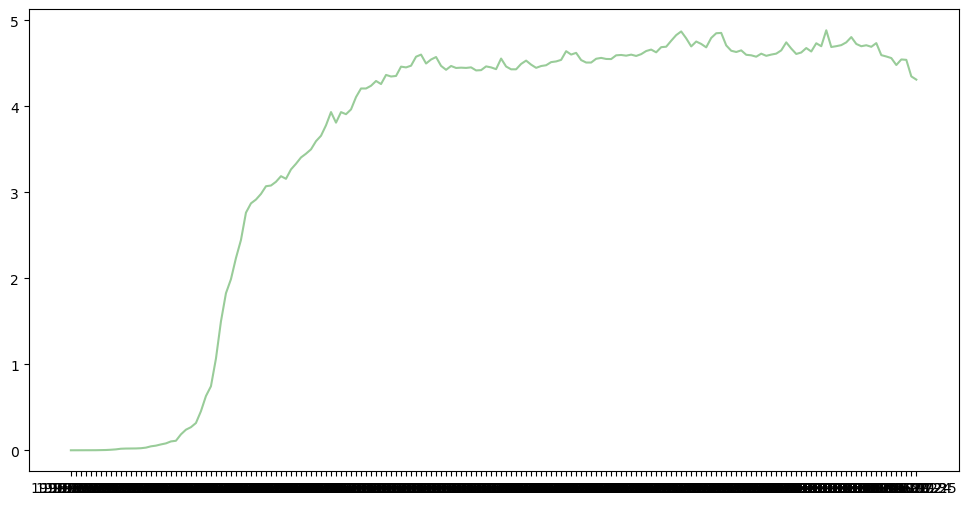

In [10]:
curves = nrj_per_plant
# curves_array = np.array(curves)

# # Calculate the envelope: min and max values for each time point
# min_values = curves_array.min(axis=0)
# max_values = curves_array.max(axis=0)

# Plotting the envelope along with individual curves for context
fig, ax = plt.subplots(figsize=(12, 6))
time_points = dates
for curve in curves:
    ax.plot(time_points, [nrj*sowing_density/par for nrj,par in zip(curve, par_incident)], color=archicrop_color, alpha=0.4, label="ArchiCrop x Caribu")

# ax.fill_between(time_points, min_values, max_values, color="skyblue", alpha=0.4)
# ax.plot(time_points, min_values, color="blue", linestyle="--", label="Min 3D")
# ax.plot(time_points, max_values, color="red", linestyle="--", label="Max 3D")
ax.plot(time_points, par_stics, color=stics_color, label="STICS")

# Labels and legend
ax.set_xticks(np.arange(0, len(dates)+1, (len(dates)+1)/8))
ax.set_xlabel("Thermal time") 
ax.set_ylabel("Fraction of absorbed PAR")
ax.set_title("Fraction of absorbed PAR: 3D canopy vs. STICS")
ax.legend()
plt.show()

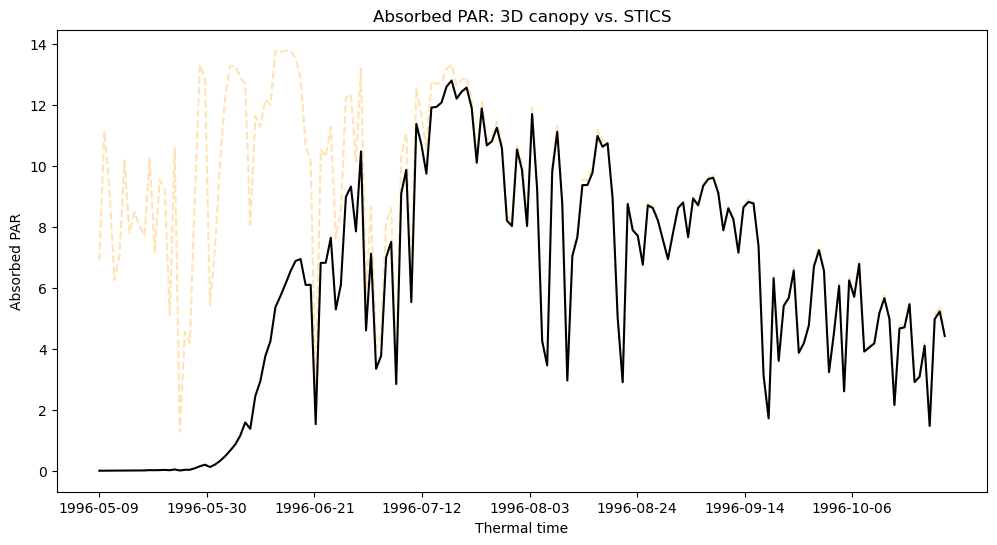

In [ ]:
start = 0
end = len(time_points)-1

fig, ax = plt.subplots(figsize=(12, 6))

for curve in curves:
    ax.plot([t for c,t in enumerate(time_points) if c%1==0][start:end], [i*sowing_density for i,par in zip(curve, par_incident)][start:end], alpha=1, linestyle='-')  # Plot each curve (optional for visualization)

ax.plot(time_points[start:end], par_incident[start:end], "--", color="orange", alpha=0.3, label="STICS")
ax.plot(time_points[start:end], [i*par for i,par in zip(par_stics, par_incident)][start:end], color="black", label="STICS")

# plt.plot(thermal_time, raint)

# Labels and legend
ax.set_xticks(np.arange(0, len(dates)+1, (len(dates)+1)/8))
ax.set_xlabel("Thermal time")
ax.set_ylabel("Absorbed PAR")
ax.set_title("Absorbed PAR: 3D canopy vs. STICS")
# plt.legend()
plt.show()

In [ ]:
# see if sum eabs and esoil = 1
# see tests caribu (cf light vege manager in oa incubator)
# compute memory 

$$ raint(t)=0.95⋅parsurrgG⋅trg(t)⋅(1−exp(−extinP⋅(lai(t)+eai(t)))) $$

$$ parsurrgG = 0.48 $$

$$ extinP(maize) = 0.7 $$

In [ ]:
"""
# vertical light interception
cs, ei, df = illuminate(scene, scene_unit='cm')
cs.plot(ei)


# diffuse light interception
sources = skys.sky_sources()
cs, ei, df = illuminate(scene, light=sources, scene_unit='cm')
cs.plot(ei)

# get score per plant
def score(res):
    return pd.Series({'ei':(res.Ei*res.area).sum() / res.area.sum(),
                              'area': res.area.sum()})
df['nump']=nump
df.groupby('nump').apply(score)
"""

"\n# vertical light interception\ncs, ei, df = illuminate(scene, scene_unit='cm')\ncs.plot(ei)\n\n\n# diffuse light interception\nsources = skys.sky_sources()\ncs, ei, df = illuminate(scene, light=sources, scene_unit='cm')\ncs.plot(ei)\n\n# get score per plant\ndef score(res):\n    return pd.Series({'ei':(res.Ei*res.area).sum() / res.area.sum(),\n                              'area': res.area.sum()})\ndf['nump']=nump\ndf.groupby('nump').apply(score)\n"